In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import math

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class DifferentialAttention(nn.Module):
    """
    Differential Attention as described in the Differential Transformer paper
    Following the pseudocode:
    
    def DiffAttn(X, W_q, W_k, W_v, λ):
        Q1, Q2 = split(X @ W_q)
        K1, K2 = split(X @ W_k)
        V = X @ W_v
        # Qi, Ki: [b, n, d]; V: [b, n, 2d]
        s = 1 / sqrt(d)
        A1 = Q1 @ K1.transpose(−1, −2) ∗ s
        A2 = Q2 @ K2.transpose(−1, −2) ∗ s
        return (softmax(A1) − λ softmax(A2)) @ V
    """
    def __init__(self, d_model, d_head, lambda_val=0.5):
        super(DifferentialAttention, self).__init__()
        self.d_head = d_head
        self.scale = 1.0 / math.sqrt(d_head)
        self.lambda_val = lambda_val
        
        # Single projections that will be split into positive/negative parts
        self.q_proj = nn.Linear(d_model, d_head * 2)
        self.k_proj = nn.Linear(d_model, d_head * 2)
        self.v_proj = nn.Linear(d_model, d_head)
    
    def forward(self, x, mask=None):
        # Project and split query and key
        q = self.q_proj(x)  # [batch, seq_len, d_head*2]
        k = self.k_proj(x)  # [batch, seq_len, d_head*2]
        v = self.v_proj(x)  # [batch, seq_len, d_head]
        
        # Split into positive and negative parts
        q1, q2 = torch.chunk(q, 2, dim=-1)  # [batch, seq_len, d_head]
        k1, k2 = torch.chunk(k, 2, dim=-1)  # [batch, seq_len, d_head]
        
        # Calculate attention scores
        attn_scores1 = torch.matmul(q1, k1.transpose(-2, -1)) * self.scale
        attn_scores2 = torch.matmul(q2, k2.transpose(-2, -1)) * self.scale
        
        # Apply mask if provided
        if mask is not None:
            attn_scores1 = attn_scores1.masked_fill(mask == 0, -1e9)
            attn_scores2 = attn_scores2.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attn_weights1 = F.softmax(attn_scores1, dim=-1)
        attn_weights2 = F.softmax(attn_scores2, dim=-1)
        
        # Calculate differential attention (positive - λ*negative)
        diff_attn = attn_weights1 - self.lambda_val * attn_weights2
        
        # Apply attention to values
        output = torch.matmul(diff_attn, v)
        
        return output

class MultiHeadDifferentialAttention(nn.Module):
    """
    Multi-Head Differential Attention as described in the paper
    
    Following the pseudocode:
    def MultiHead(X, W_q, W_k, W_v, W_o, λ):
        O = GroupNorm([DiffAttn(X, W_qi, W_ki, W_vi, λ) for i in range(h)])
        O = O ∗ (1 − λinit)
        return Concat(O) @ W_o
    """
    def __init__(self, d_model, num_heads, lambda_init=0.5):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.lambda_init = lambda_init
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_head = d_model // num_heads
        
        # Create multiple differential attention heads
        self.heads = nn.ModuleList([
            DifferentialAttention(d_model, self.d_head, lambda_init)
            for _ in range(num_heads)
        ])
        
        # Use LayerNorm instead of GroupNorm to avoid dimension issues
        # LayerNorm is also typically used in transformers
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Final projection
        self.output_proj = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        
        # Apply differential attention for each head
        head_outputs = [head(x, mask) for head in self.heads]
        
        # Concatenate outputs from all heads
        multi_head_output = torch.cat(head_outputs, dim=-1)
        
        # Apply layer normalization
        multi_head_output = self.layer_norm(multi_head_output)
        
        # Scale output by (1 - λinit) as mentioned in the paper
        multi_head_output = multi_head_output * (1 - self.lambda_init)
        
        # Final projection
        output = self.output_proj(multi_head_output)
        
        return output

class TransformerEncoderLayer(nn.Module):
    """Transformer Encoder Layer with Differential Attention"""
    def __init__(self, d_model, num_heads, dim_ff, dropout=0.1, lambda_init=0.5):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Use differential attention
        self.attention = MultiHeadDifferentialAttention(d_model, num_heads, lambda_init)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Pre-LayerNorm architecture
        attn_output = self.attention(self.norm1(x), mask)
        # Residual connection
        x = x + self.dropout(attn_output)
        
        # Feed forward with residual connection
        ff_output = self.ffn(self.norm2(x))
        x = x + self.dropout(ff_output)
        
        return x

class DifferentialVisionTransformer(nn.Module):
    """
    Vision Transformer with Differential Attention
    """
    def __init__(self, 
                 image_size=32,        # CIFAR-10 image size
                 patch_size=4,         # patch size (2 or 4)
                 in_channels=3,        # RGB images
                 num_classes=10,       # CIFAR-10 has 10 classes
                 d_model=192,          # embedding dimension
                 num_heads=8,          # number of heads in attention
                 num_layers=8,         # number of transformer encoder layers
                 dim_ff=768,           # feed-forward network dimension
                 dropout=0.1,
                 lambda_init=0.5):     # lambda parameter for differential attention
        super(DifferentialVisionTransformer, self).__init__()
        
        # Image and patch parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        
        # Calculate the number of patches
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        
        # Linear projection of flattened patches
        self.patch_embedding = nn.Linear(patch_dim, d_model)
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        
        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        
        # Dropout after position embedding
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder with differential attention
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, dim_ff, dropout, lambda_init)
            for _ in range(num_layers)
        ])
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
        
        # MLP Head for classification
        self.mlp_head = nn.Linear(d_model, num_classes)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        # Initialize patch embedding
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.zeros_(self.patch_embedding.bias)
        
        # Initialize cls token
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Initialize position embedding
        nn.init.normal_(self.pos_embedding, std=0.02)
        
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        batch_size = x.shape[0]
        
        # Extract patches: [B, C, H, W] -> [B, num_patches, C*P*P]
        # Where P is the patch size
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, self.in_channels, -1, self.patch_size * self.patch_size)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.in_channels * self.patch_size * self.patch_size)
        
        # Linear embedding of patches
        x = self.patch_embedding(x)  # [B, num_patches, d_model]
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, d_model]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1+num_patches, d_model]
        
        # Add positional embedding
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Apply transformer encoder layers with differential attention
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Apply layer normalization
        x = self.norm(x)
        
        # Take the cls token representation
        x = x[:, 0]  # [B, d_model]
        
        # Classification head
        x = self.mlp_head(x)  # [B, num_classes]
        
        return x

def get_data_loaders(batch_size=128):
    """Create CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Create a validation set
    val_size = 5000
    train_size = len(trainset) - val_size
    
    train_subset, val_subset = torch.utils.data.random_split(
        trainset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42))
    
    valloader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    train_subset_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_subset_loader, valloader, testloader

def train_model(model, train_loader, val_loader, epochs=30, lr=3e-4, weight_decay=1e-4, model_name='diff_vit'):
    """Train the Differential Vision Transformer model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # For saving the best model
    best_val_acc = 0
    best_model_path = f'best_{model_name}_model.pth'
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': train_loss/(batch_idx+1), 
                'acc': 100.*correct/total
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                pbar.set_postfix({
                    'loss': val_loss/(batch_idx+1), 
                    'acc': 100.*correct/total
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print stats
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # Save the best model
        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%, saving model...')
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
        
        # Update learning rate
        scheduler.step()
    
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    return train_losses, train_accs, val_losses, val_accs

def evaluate_model(model, test_loader):
    """Evaluate the trained model on the test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating on test set'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_acc = 100. * correct / total
    print(f'Test accuracy: {test_acc:.2f}%')
    return test_acc

def plot_metrics(train_losses, val_losses, train_accs, val_accs, title_suffix="", filename_prefix="diff_vit"):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss{title_suffix}')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy{title_suffix}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_metrics.png')
    plt.show()


100%|██████████| 170M/170M [00:03<00:00, 49.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Differential ViT created with 4.18M parameters

=== Training Differential ViT ===
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.80it/s, loss=1.54, acc=43.8]


Epoch 1/50:
Train Loss: 1.7794 | Train Acc: 33.70%
Val Loss: 1.5359 | Val Acc: 43.78%
Validation accuracy improved from 0.00% to 43.78%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.28it/s, loss=1.42, acc=48.3]


Epoch 2/50:
Train Loss: 1.4768 | Train Acc: 45.93%
Val Loss: 1.4173 | Val Acc: 48.28%
Validation accuracy improved from 43.78% to 48.28%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.35it/s, loss=1.24, acc=54.7]


Epoch 3/50:
Train Loss: 1.3249 | Train Acc: 51.75%
Val Loss: 1.2396 | Val Acc: 54.66%
Validation accuracy improved from 48.28% to 54.66%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.45it/s, loss=1.15, acc=58.3]


Epoch 4/50:
Train Loss: 1.2328 | Train Acc: 55.27%
Val Loss: 1.1534 | Val Acc: 58.26%
Validation accuracy improved from 54.66% to 58.26%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.81it/s, loss=1.12, acc=59.2]


Epoch 5/50:
Train Loss: 1.1565 | Train Acc: 57.90%
Val Loss: 1.1241 | Val Acc: 59.18%
Validation accuracy improved from 58.26% to 59.18%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.22it/s, loss=1.08, acc=60.6]


Epoch 6/50:
Train Loss: 1.1020 | Train Acc: 60.14%
Val Loss: 1.0829 | Val Acc: 60.58%
Validation accuracy improved from 59.18% to 60.58%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.02it/s, loss=1.01, acc=63.7]


Epoch 7/50:
Train Loss: 1.0538 | Train Acc: 62.02%
Val Loss: 1.0109 | Val Acc: 63.72%
Validation accuracy improved from 60.58% to 63.72%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.45it/s, loss=0.971, acc=64.5]


Epoch 8/50:
Train Loss: 1.0113 | Train Acc: 63.82%
Val Loss: 0.9707 | Val Acc: 64.50%
Validation accuracy improved from 63.72% to 64.50%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.10it/s, loss=0.96, acc=65.5]


Epoch 9/50:
Train Loss: 0.9631 | Train Acc: 65.54%
Val Loss: 0.9598 | Val Acc: 65.54%
Validation accuracy improved from 64.50% to 65.54%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.80it/s, loss=0.929, acc=67.1]


Epoch 10/50:
Train Loss: 0.9249 | Train Acc: 66.86%
Val Loss: 0.9287 | Val Acc: 67.14%
Validation accuracy improved from 65.54% to 67.14%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.73it/s, loss=0.874, acc=68.7]


Epoch 11/50:
Train Loss: 0.8890 | Train Acc: 68.25%
Val Loss: 0.8743 | Val Acc: 68.74%
Validation accuracy improved from 67.14% to 68.74%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.55it/s, loss=0.846, acc=69.5]


Epoch 12/50:
Train Loss: 0.8653 | Train Acc: 69.16%
Val Loss: 0.8457 | Val Acc: 69.54%
Validation accuracy improved from 68.74% to 69.54%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.00it/s, loss=0.827, acc=70.4]


Epoch 13/50:
Train Loss: 0.8339 | Train Acc: 69.97%
Val Loss: 0.8267 | Val Acc: 70.38%
Validation accuracy improved from 69.54% to 70.38%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.63it/s, loss=0.856, acc=70.6]


Epoch 14/50:
Train Loss: 0.8021 | Train Acc: 71.22%
Val Loss: 0.8560 | Val Acc: 70.62%
Validation accuracy improved from 70.38% to 70.62%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.00it/s, loss=0.809, acc=71.7]


Epoch 15/50:
Train Loss: 0.7763 | Train Acc: 72.36%
Val Loss: 0.8094 | Val Acc: 71.72%
Validation accuracy improved from 70.62% to 71.72%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.91it/s, loss=0.769, acc=73.1]


Epoch 16/50:
Train Loss: 0.7426 | Train Acc: 73.47%
Val Loss: 0.7694 | Val Acc: 73.14%
Validation accuracy improved from 71.72% to 73.14%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.60it/s, loss=0.774, acc=72.6]


Epoch 17/50:
Train Loss: 0.7171 | Train Acc: 74.57%
Val Loss: 0.7741 | Val Acc: 72.64%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.11it/s, loss=0.752, acc=74.1]


Epoch 18/50:
Train Loss: 0.6931 | Train Acc: 75.35%
Val Loss: 0.7518 | Val Acc: 74.12%
Validation accuracy improved from 73.14% to 74.12%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.20it/s, loss=0.725, acc=74.3]


Epoch 19/50:
Train Loss: 0.6693 | Train Acc: 76.12%
Val Loss: 0.7253 | Val Acc: 74.32%
Validation accuracy improved from 74.12% to 74.32%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.60it/s, loss=0.733, acc=75]


Epoch 20/50:
Train Loss: 0.6511 | Train Acc: 76.89%
Val Loss: 0.7334 | Val Acc: 74.96%
Validation accuracy improved from 74.32% to 74.96%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.44it/s, loss=0.756, acc=73.6]


Epoch 21/50:
Train Loss: 0.6230 | Train Acc: 77.81%
Val Loss: 0.7556 | Val Acc: 73.62%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.16it/s, loss=0.72, acc=74.8]


Epoch 22/50:
Train Loss: 0.6000 | Train Acc: 78.52%
Val Loss: 0.7201 | Val Acc: 74.76%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.27it/s, loss=0.732, acc=75.4]


Epoch 23/50:
Train Loss: 0.5816 | Train Acc: 79.28%
Val Loss: 0.7322 | Val Acc: 75.40%
Validation accuracy improved from 74.96% to 75.40%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.31it/s, loss=0.687, acc=76.5]


Epoch 24/50:
Train Loss: 0.5588 | Train Acc: 79.99%
Val Loss: 0.6867 | Val Acc: 76.46%
Validation accuracy improved from 75.40% to 76.46%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.02it/s, loss=0.723, acc=75.3]


Epoch 25/50:
Train Loss: 0.5400 | Train Acc: 80.81%
Val Loss: 0.7231 | Val Acc: 75.30%


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.26it/s, loss=0.702, acc=75.9]


Epoch 26/50:
Train Loss: 0.5192 | Train Acc: 81.43%
Val Loss: 0.7020 | Val Acc: 75.92%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.57it/s, loss=0.661, acc=77.9]


Epoch 27/50:
Train Loss: 0.4957 | Train Acc: 82.24%
Val Loss: 0.6607 | Val Acc: 77.90%
Validation accuracy improved from 76.46% to 77.90%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.94it/s, loss=0.693, acc=76.8]


Epoch 28/50:
Train Loss: 0.4752 | Train Acc: 83.07%
Val Loss: 0.6935 | Val Acc: 76.84%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.36it/s, loss=0.692, acc=77]


Epoch 29/50:
Train Loss: 0.4592 | Train Acc: 83.70%
Val Loss: 0.6924 | Val Acc: 77.00%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.31it/s, loss=0.679, acc=77.6]


Epoch 30/50:
Train Loss: 0.4447 | Train Acc: 84.05%
Val Loss: 0.6788 | Val Acc: 77.60%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.92it/s, loss=0.705, acc=77.6]


Epoch 31/50:
Train Loss: 0.4262 | Train Acc: 84.71%
Val Loss: 0.7050 | Val Acc: 77.62%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.47it/s, loss=0.705, acc=77.5]


Epoch 32/50:
Train Loss: 0.4085 | Train Acc: 85.34%
Val Loss: 0.7050 | Val Acc: 77.46%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.06it/s, loss=0.713, acc=77.8]


Epoch 33/50:
Train Loss: 0.3950 | Train Acc: 85.84%
Val Loss: 0.7133 | Val Acc: 77.84%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.05it/s, loss=0.704, acc=77.7]


Epoch 34/50:
Train Loss: 0.3775 | Train Acc: 86.49%
Val Loss: 0.7039 | Val Acc: 77.66%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.59it/s, loss=0.712, acc=77.2]


Epoch 35/50:
Train Loss: 0.3603 | Train Acc: 87.14%
Val Loss: 0.7124 | Val Acc: 77.18%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.24it/s, loss=0.757, acc=77.8]


Epoch 36/50:
Train Loss: 0.3452 | Train Acc: 87.44%
Val Loss: 0.7566 | Val Acc: 77.84%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.35it/s, loss=0.71, acc=78.3]


Epoch 37/50:
Train Loss: 0.3383 | Train Acc: 87.89%
Val Loss: 0.7105 | Val Acc: 78.26%
Validation accuracy improved from 77.90% to 78.26%, saving model...


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.24it/s, loss=0.702, acc=78.8]


Epoch 38/50:
Train Loss: 0.3214 | Train Acc: 88.46%
Val Loss: 0.7018 | Val Acc: 78.76%
Validation accuracy improved from 78.26% to 78.76%, saving model...


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.86it/s, loss=0.749, acc=78]


Epoch 39/50:
Train Loss: 0.3146 | Train Acc: 88.69%
Val Loss: 0.7485 | Val Acc: 77.96%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.90it/s, loss=0.709, acc=79.3]


Epoch 40/50:
Train Loss: 0.3019 | Train Acc: 89.32%
Val Loss: 0.7092 | Val Acc: 79.30%
Validation accuracy improved from 78.76% to 79.30%, saving model...


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.54it/s, loss=0.733, acc=78.6]


Epoch 41/50:
Train Loss: 0.2877 | Train Acc: 89.84%
Val Loss: 0.7335 | Val Acc: 78.56%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.87it/s, loss=0.74, acc=78.1]


Epoch 42/50:
Train Loss: 0.2854 | Train Acc: 89.86%
Val Loss: 0.7402 | Val Acc: 78.08%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.64it/s, loss=0.742, acc=78.4]


Epoch 43/50:
Train Loss: 0.2771 | Train Acc: 90.12%
Val Loss: 0.7422 | Val Acc: 78.36%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.15it/s, loss=0.745, acc=78.1]


Epoch 44/50:
Train Loss: 0.2688 | Train Acc: 90.47%
Val Loss: 0.7447 | Val Acc: 78.10%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.04it/s, loss=0.742, acc=78.8]


Epoch 45/50:
Train Loss: 0.2666 | Train Acc: 90.54%
Val Loss: 0.7420 | Val Acc: 78.82%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.12it/s, loss=0.734, acc=78.6]


Epoch 46/50:
Train Loss: 0.2643 | Train Acc: 90.57%
Val Loss: 0.7336 | Val Acc: 78.64%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.01it/s, loss=0.75, acc=78.7]


Epoch 47/50:
Train Loss: 0.2625 | Train Acc: 90.58%
Val Loss: 0.7495 | Val Acc: 78.68%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.29it/s, loss=0.783, acc=77.9]


Epoch 48/50:
Train Loss: 0.2588 | Train Acc: 90.83%
Val Loss: 0.7832 | Val Acc: 77.94%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.28it/s, loss=0.778, acc=77.7]


Epoch 49/50:
Train Loss: 0.2573 | Train Acc: 90.88%
Val Loss: 0.7783 | Val Acc: 77.68%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.56it/s, loss=0.77, acc=78.3]


Epoch 50/50:
Train Loss: 0.2547 | Train Acc: 90.89%
Val Loss: 0.7703 | Val Acc: 78.28%
Best validation accuracy: 79.30%


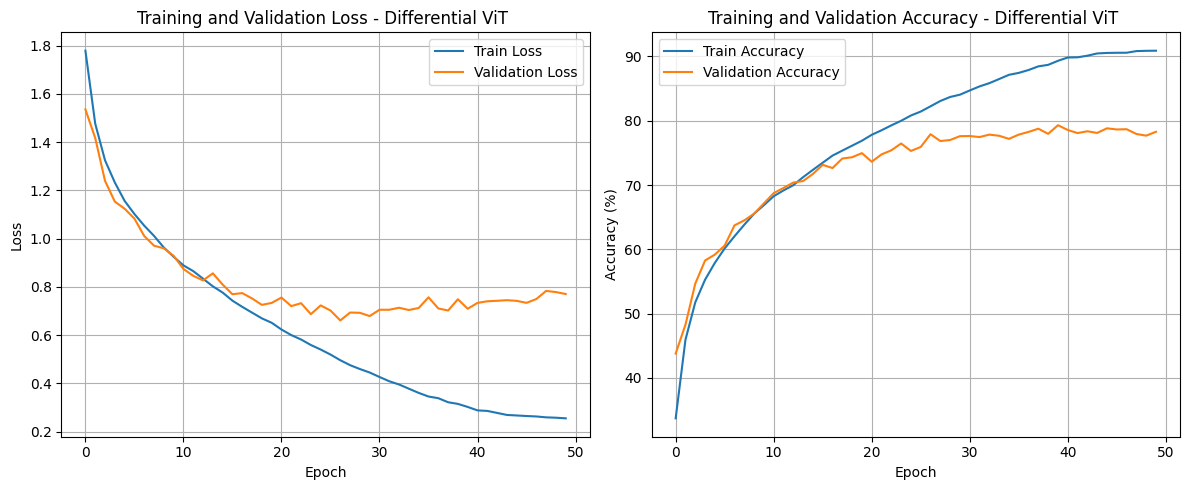

/tmp/ipykernel_19/190808894.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f'best_{model_name}_model.pth'))



=== Loading Best Model for Evaluation ===


Evaluating on test set: 100%|██████████| 79/79 [00:03<00:00, 25.42it/s]

Test accuracy: 79.64%

=== Final Results ===
Differential ViT : Test Accuracy = 79.64%


In [2]:

# Hyperparameters
batch_size = 128
epochs = 50
lr = 3e-4
weight_decay = 1e-4
patch_size = 4 
lambda_init = 0.5  # Initial lambda value for differential attention

# Get data loaders
train_loader, val_loader, test_loader = get_data_loaders(batch_size)

# Create differential ViT model
diff_vit = DifferentialVisionTransformer(
    image_size=32, 
    patch_size=patch_size, 
    in_channels=3, 
    num_classes=10,
    d_model=192, 
    num_heads=8, 
    num_layers=8, 
    dim_ff=768,
    dropout=0.1,
    lambda_init=lambda_init
)

print(f"Differential ViT created with {sum(p.numel() for p in diff_vit.parameters())/1e6:.2f}M parameters")

# Train the model
print("\n=== Training Differential ViT ===")
model_name = f"diff_vit_p{patch_size}"
train_losses, train_accs, val_losses, val_accs = train_model(
    diff_vit, train_loader, val_loader, 
    epochs=epochs, lr=lr, weight_decay=weight_decay,
    model_name=model_name
)

# Plot training metrics
plot_metrics(
    train_losses, val_losses, train_accs, val_accs,
    title_suffix=f" - Differential ViT ",
    filename_prefix=model_name
)

# Load the best model and evaluate
print("\n=== Loading Best Model for Evaluation ===")
best_model = DifferentialVisionTransformer(
    image_size=32, 
    patch_size=patch_size, 
    in_channels=3, 
    num_classes=10,
    d_model=192, 
    num_heads=8, 
    num_layers=8, 
    dim_ff=768,
    dropout=0.1,
    lambda_init=lambda_init
)
best_model.load_state_dict(torch.load(f'best_{model_name}_model.pth'))

# Evaluate on test set
test_acc = evaluate_model(best_model, test_loader)

# Print final result
print("\n=== Final Results ===")
print(f"Differential ViT : Test Accuracy = {test_acc:.2f}%")

# # Also try with different patch size if needed
# if patch_size == 4:
#     print("\nAlso trying with patch size 2...")
#     patch_size = 2
#     model_name = f"diff_vit_p{patch_size}"
    
#     diff_vit_p2 = DifferentialVisionTransformer(
#         image_size=32, 
#         patch_size=patch_size, 
#         in_channels=3, 
#         num_classes=10,
#         d_model=192, 
#         num_heads=8, 
#         num_layers=8, 
#         dim_ff=768,
#         dropout=0.1,
#         lambda_init=lambda_init
#     )
    
#     print(f"Differential ViT created with {sum(p.numel() for p in diff_vit_p2.parameters())/1e6:.2f}M parameters")
    
#     # Train with patch size 2
#     train_losses, train_accs, val_losses, val_accs = train_model(
#         diff_vit_p2, train_loader, val_loader, 
#         epochs=epochs, lr=lr, weight_decay=weight_decay,
#         model_name=model_name
#     )
    
#     # Plot metrics
#     plot_metrics(
#         train_losses, val_losses, train_accs, val_accs,
#         title_suffix=f" - Differential ViT (patch_size={patch_size})",
#         filename_prefix=model_name
#     )
    
#     # Load best model with patch size 2 and evaluate
#     best_model_p2 = DifferentialVisionTransformer(
#         image_size=32, 
#         patch_size=patch_size, 
#         in_channels=3, 
#         num_classes=10,
#         d_model=192, 
#         num_heads=8, 
#         num_layers=8, 
#         dim_ff=768,
#         dropout=0.1,
#         lambda_init=lambda_init
#     )
#     best_model_p2.load_state_dict(torch.load(f'best_{model_name}_model.pth'))
    
#     test_acc_p2 = evaluate_model(best_model_p2, test_loader)
#     print(f"Differential ViT with patch size {patch_size}: Test Accuracy = {test_acc_p2:.2f}%")



### Comparison with standard ViT:

Standard ViT outperformed Differential ViT on CIFAR-10 (81.22% vs 79.64%). This 1.6% gap suggests that while promising, DiffViT's attention mechanism may need refinement for this task. The underperformance could be due to suboptimal lambda parameter tuning, insufficient training data for the more complex mechanism, or differential attention being better suited for tasks requiring explicit feature contrast. Despite lower accuracy, DiffViT's approach to modeling both positive and negative attention relationships remains an innovative contribution to vision transformers.